# 2 - Difference in Differences

### Geotesting to Determine Paid Media Incremental Impact

Difference in differences is super helpful for situations where some factor affects two time series differently. It uses the trend from one time series as a reference for how things could or should happen in a second trend, and yields an effect size that's related to how disproportinately that second trend was affected.


If that's a confusing explanation- here's an example!

The data set we'll use is from a chain of Drugstores in Europe that spans a portion of 2015.

To understand the incrementaility of Paid Media, I've simulated some "geomatching" to identify a synthetic "control baseline" group of geographies and a "test holdout" group, both of which represent a subset of geographies of all of the regions in which the stores make sales.

The Test group will simulate a region where all Paid Media is halted, which can be compared against the matched "control baseline" geos to better understand the true causal impact of running paid campaigns.

In [1]:
## import required packages

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [2]:
adf = pd.read_parquet('data/rossmann_sales.parquet')
adf.sample(5)

geo_group,date,dayofweek,all_others,control_baseline,test_holdout,total_sales
36,2015-03-09,1,3747200,1806450,1.211379e+06,6.765029e+06
73,2015-04-15,3,4434280,2141709,1.426522e+06,8.002511e+06
153,2015-07-04,6,3310475,1645453,6.787963e+05,5.634724e+06
110,2015-05-22,5,4619546,2249791,1.132563e+06,8.001900e+06
77,2015-04-19,7,125321,91183,2.083800e+04,2.373420e+05


For reference, here's the overall trend of Sales over time in our data set. It's difficult to see exactly where the test started since it's only running in a small set of geographies.

<Figure size 640x480 with 0 Axes>

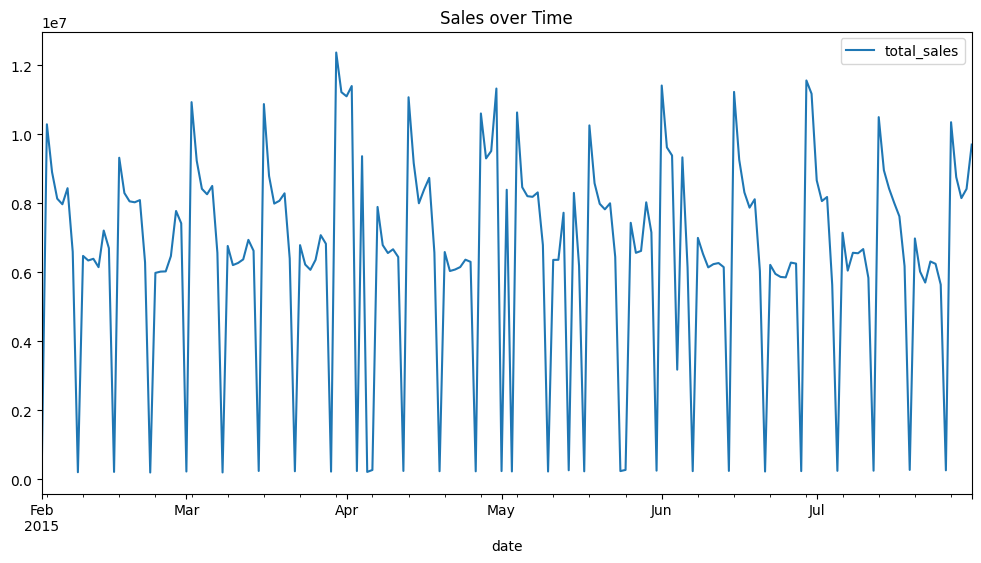

In [3]:
plt.figure()
adf.plot(x='date', y='total_sales', figsize=(12,6), title='Sales over Time')
plt.show()

The test started on May 1- here's a better visualization to see the sales by their test group:

In [4]:
test_date = dt.datetime(2015, 5, 1)

<Figure size 640x480 with 0 Axes>

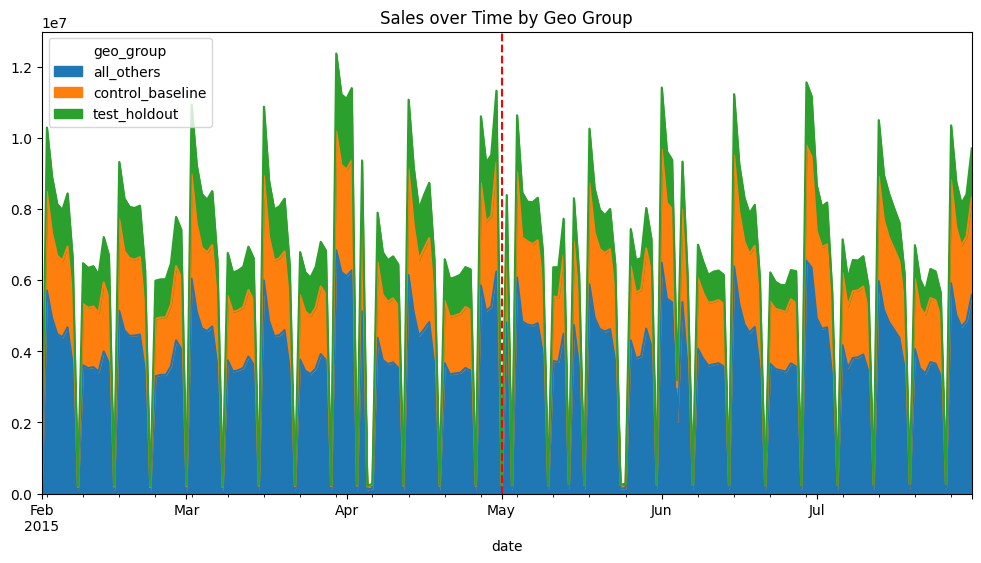

In [5]:
plt.figure()
adf.plot(x='date', y=['all_others', 'control_baseline', 'test_holdout'], kind='area', stacked=True, figsize=(12,6), title='Sales over Time by Geo Group')
plt.axvline(test_date, color='r', linestyle='--')
plt.show()

This specifically shows the trends for sales for the two groups in the test. For the sake of this example & for visual effect, I simulated an uneven distribution between the control & test groups.

This could possibly happen in the real world if you were attempting to minimize the opportunity cost of turning off Ads in markets/regions.

<Figure size 640x480 with 0 Axes>

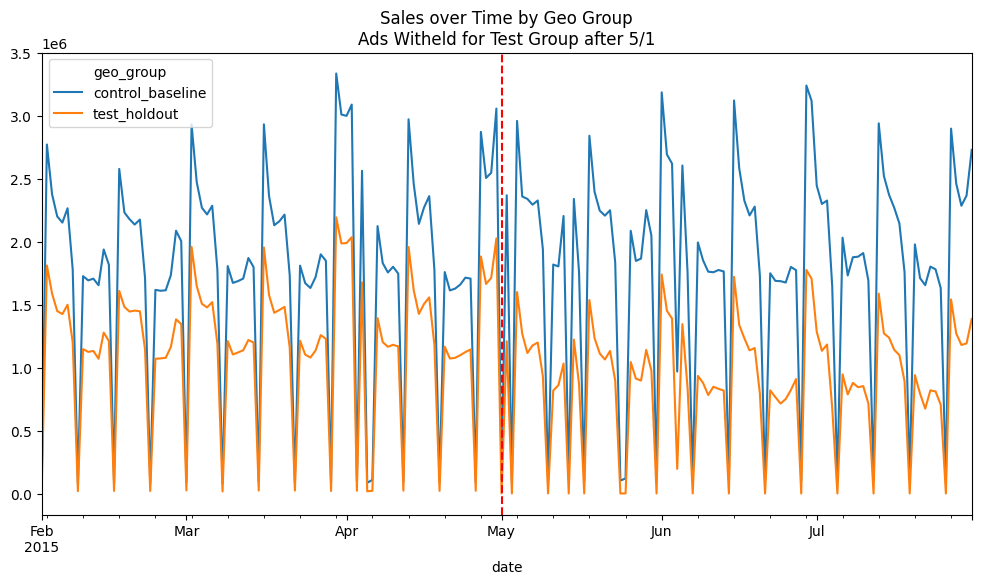

In [6]:
plt.figure()
adf.plot(x='date', y=['control_baseline', 'test_holdout'], figsize=(12,6), title='Sales over Time by Geo Group\nAds Witheld for Test Group after 5/1')
plt.axvline(test_date, color='r', linestyle='--')
plt.show()

Difference in Differences assumes that:
  - one time series can be expressed as a linear multiple of another (the first "difference")
  - in the absence of a treatment, external effects change trends both time series the same way at the intervention date (the second "difference")
  - the effect size is thus how much the treatment group changes beyond what those first two assumptions predict (the difference in differences)


The "warmup" or pre-test period is important because it establishes our baseline for what the typical variation for sales looks like in both sets of geographies. A lack of sufficient clean pre-test data can limit the statistical power of DiD

To capture this information in a regression model, we need to update our data set:
- Structure our data such that 1 row = 1 observation (tidy data)
- Create an indicator variable that specifies which group the sales figure comes from (1's & 0's, no strings)
- Create an indicator variable that specifies if the date is before or after the test started

In [7]:
## Create a tidy data frame that ignores the "total sales" and "all others" columns
df = adf.drop(columns=['total_sales', 'all_others']).melt(id_vars=['date', 'dayofweek'], var_name='geo_group', value_name='sales').copy()
df.sample(5)

,date,dayofweek,geo_group,sales
113,2015-05-25,1,control_baseline,1.200970e+05
183,2015-02-03,2,test_holdout,1.588841e+06
339,2015-07-09,4,test_holdout,8.444223e+05
109,2015-05-21,4,control_baseline,2.207324e+06
34,2015-03-07,6,control_baseline,1.778072e+06


In [8]:
## Threshold the data based on the test date
df['days_post'] = df.apply(lambda x: (x['date'] - test_date).days, axis=1)
df['threshold'] = df.days_post.apply(lambda x: 1 if x>0 else 0)

## is_affected is a binary variable that indicates whether the data point is from the test group
df['is_affected'] = df.geo_group.apply(lambda x: 1 if x=='test_holdout' else 0)
df.tail()

,date,dayofweek,geo_group,sales,days_post,threshold,is_affected
357,2015-07-27,1,test_holdout,1.541681e+06,87,1,1
358,2015-07-28,2,test_holdout,1.271698e+06,88,1,1
359,2015-07-29,3,test_holdout,1.180251e+06,89,1,1
360,2015-07-30,4,test_holdout,1.192172e+06,90,1,1
361,2015-07-31,5,test_holdout,1.385702e+06,91,1,1


Now, let's get an intuitive sense of how Diff in Diff will compute our effect size:

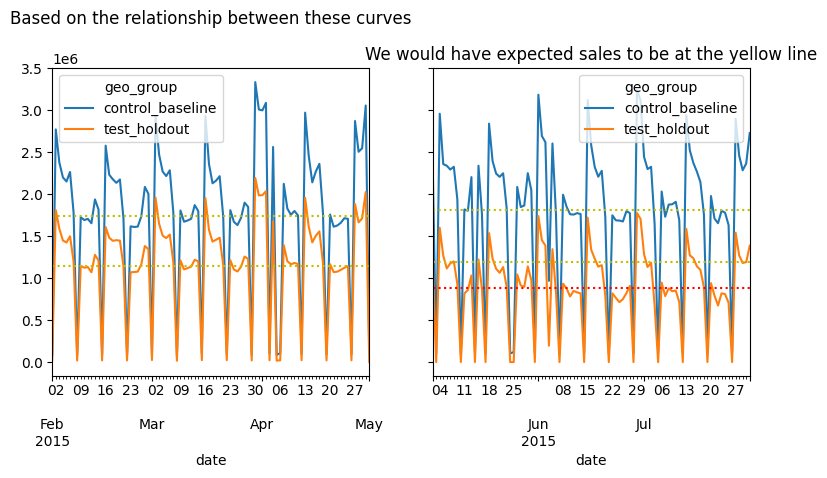

In [9]:
fig,ax = plt.subplots(1,2,sharey=True)

df[df.date <= test_date].groupby(['date', 'geo_group']).sales.sum().unstack().plot(
    ax=ax[0],
    figsize=(9,4),
    title='Based on the relationship between these curves\n'
)

ax[0].axhline(
    df[(df.threshold==0)&(df.geo_group=='control_baseline')].sales.mean(),
    color='y',
    linestyle=':',
)

ax[0].axhline(
    df[(df.threshold==0)&(df.geo_group=='test_holdout')].sales.mean(),
    color='y',
    linestyle=':',
)

df[df.date > test_date].groupby(['date', 'geo_group']).sales.sum().unstack().plot(
    ax=ax[1],
    figsize=(9,4),
    title='\nWe would have expected sales to be at the yellow line'
)

ax[1].axhline(
    df[(df.threshold==1)&(df.geo_group=='control_baseline')].sales.mean(),
    color='y',
    linestyle=':',
)

ax[1].axhline(
    df[(df.threshold==1)&(df.geo_group=='test_holdout')].sales.mean(),
    color='r',
    linestyle=':',
)

pre_ratio = df[(df.threshold==0)&(df.geo_group=='test_holdout')].sales.mean() / df[(df.threshold==0)&(df.geo_group=='control_baseline')].sales.mean()
post_expected = pre_ratio*df[(df.threshold==1)&(df.geo_group=='control_baseline')].sales.mean()

ax[1].axhline(
    post_expected,
    color='y',
    linestyle=':',
)

plt.show()

![static image of diff in diff visualized](img/did_visualized.png "Title")

The lines are drawn at means of the each time series in the regions. The Control's line pre- and post- look similar, but they actually differ slightly because of the change in sales trends that happen external to our test.

Our effect size will be the distance between the lower yellow line and the red line.

The most simple Diff-in-Diff setup is essentially a groupwise comparison of means, done in a manner that allows one to compute test statistics.

Let's compute this effect size directly using a linear model

In [10]:
lm = smf.ols(formula='sales ~ threshold*is_affected', data=df)
result = lm.fit()


![alt text](img/ols.png "Title")

In [11]:
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     35.44
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           4.44e-20
Time:                        22:46:21   Log-Likelihood:                -5395.7
No. Observations:                 362   AIC:                         1.080e+04
Df Residuals:                     358   BIC:                         1.081e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.746e+

![basic diff in diff regression table](img/2_did_simple.png "Title")

In our regression model, our interaction effect represents our effect size.

 **We observe that sales decreased by $328k each day by disabling our adspend**, which if the above assumptions are true, is the incremental daily amount driven by the paid media program.

We can visually check this on the chart above as well!

This simple example only compares the means of pre- and post-test sales by each test group. The model's R^2 shows that this doesn't actually describe much of the variation in our sales data.


Is this a problem?

It's a fair criticism that there could be other confounding factors in our pseudo-experimental setup that violate the key assumptions of our simple model. 

For example, if weekly seasonality affects sales, then we may introduce some bias into the data set if either the pre- or post- test groups have more weekends included in the data set?

Let's create a version of this model that accounts for the day-of-week effects, and see if we can improve our model's goodness-of-fit

In [12]:
df.head()

,date,dayofweek,geo_group,sales,days_post,threshold,is_affected
0,2015-02-01,7,control_baseline,86226.0,-89,0,0
1,2015-02-02,1,control_baseline,2772545.0,-88,0,0
2,2015-02-03,2,control_baseline,2377591.0,-87,0,0
3,2015-02-04,3,control_baseline,2200883.0,-86,0,0
4,2015-02-05,4,control_baseline,2152077.0,-85,0,0


In [13]:
dow_one_hot = pd.get_dummies(df.dayofweek, prefix='dow', drop_first=True, dtype=int)
dow_one_hot.head()

,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7
0,0,0,0,0,0,1
1,0,0,0,0,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,0,0,1,0,0,0


In [14]:
df = df.drop(columns=['dayofweek']).merge(dow_one_hot, left_index=True, right_index=True)
df.head()

,date,geo_group,sales,days_post,threshold,is_affected,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7
0,2015-02-01,control_baseline,86226.0,-89,0,0,0,0,0,0,0,1
1,2015-02-02,control_baseline,2772545.0,-88,0,0,0,0,0,0,0,0
2,2015-02-03,control_baseline,2377591.0,-87,0,0,1,0,0,0,0,0
3,2015-02-04,control_baseline,2200883.0,-86,0,0,0,1,0,0,0,0
4,2015-02-05,control_baseline,2152077.0,-85,0,0,0,0,1,0,0,0


In [15]:
lm2 = smf.ols(formula='sales ~ threshold*is_affected + dow_2 + dow_3 + dow_4 + dow_5 + dow_6 + dow_7', data=df)
result2 = lm2.fit()


In [16]:
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     92.40
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           3.87e-87
Time:                        22:46:21   Log-Likelihood:                -5223.2
No. Observations:                 362   AIC:                         1.047e+04
Df Residuals:                     352   BIC:                         1.051e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2.179e+

![diff in diff regression table with day of week](img/2_did_with_dayofweek.png "Title") 


With this model, we see about the same effect size of -$328k / day in sales, but with a much improved R^2 value of >0.7


This didn't do much to change our results, but controling for external factors that correlate with your target metric can help to improve your statistical power by controling for the within-group variation of each test group.

![alt text](img/between_within_group_variation.png "Title") 